In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# 1. Spark Session
spark = SparkSession.builder.getOrCreate()

# 2. Load customer data (update the path if needed)
customer_df = spark.read.csv("/mnt/data/global_customer_segments_simple.csv", header=True, inferSchema=True)

# 3. Select features for clustering
features_cols = ["Income", "Loyalty_Score", "Customer_Lifetime_Value"]
customer_data = customer_df.select(features_cols).dropna()

# 4. Vector Assembler
assembler = VectorAssembler(inputCols=features_cols, outputCol="features")
assembled_data = assembler.transform(customer_data)

# 5. KMeans Clustering
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=4)
model = kmeans.fit(assembled_data)
clustered_data = model.transform(assembled_data)

# 6. Join back with original data for reference
final_df = customer_df.join(clustered_data.select("features", "cluster"), on="features")

# 7. Convert to Pandas for visualization
pandas_clustered = final_df.select("Income", "Loyalty_Score", "Customer_Lifetime_Value", "cluster").toPandas()

# 8. Plot Clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    pandas_clustered["Income"],
    pandas_clustered["Customer_Lifetime_Value"],
    c=pandas_clustered["cluster"],
    cmap="viridis",
    alpha=0.6
)
plt.xlabel("Income")
plt.ylabel("Customer Lifetime Value")
plt.title("Customer Segmentation: KMeans Clusters")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Export to Azure SQL
jdbc_url = "jdbc:sqlserver://geeta.database.windows.net:1433;databaseName=db_dev"
connection_properties = {
    "user": "geeta@geeta",
    "password": "Chaitu@13",
    "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}

# Write clustered data to SQL
final_df.write.jdbc(url=jdbc_url, table="Customer_Segments", mode="overwrite", properties=connection_properties)

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
spark = SparkSession.builder.getOrCreate()


In [0]:
customer_df = spark.read.format("delta").load("/mnt/cleaned_data/profile_df")


In [0]:
features_cols = ["Total_Orders", "Total_Spend", "Purchase_Frequency", "Reward_Points", "Avg_Discount_Used"]
df_cleaned = customer_df.select(features_cols).dropna()

In [0]:
assembler = VectorAssembler(inputCols=features_cols, outputCol="features")
assembled = assembler.transform(df_cleaned)


In [0]:
kmeans = KMeans(k=4, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(assembled)
clustered = model.transform(assembled)

In [0]:
final_df = customer_df.join(clustered.select("features", "cluster"), on="features")

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-6118636399611898>, line 1
----> 1 final_df = customer_df.join(clustered.select("features", "cluster"), on="features")

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         module_name, class_name, function_name, time.perf_counter() - start, signature
     51     )
     52     return res

File /databricks/spark/python/pyspark/sql/dataframe.py:2432, in DataFrame.join(self, other, on, how)
   2430         on = self._jseq([])
   2431     assert isinstance(how, str), "how should be a string"
-> 2432     jdf = self._jdf.join(other._jdf, on, how)
   2433 return DataFrame(jdf, self.sparkSession)

File /databricks/spark/python/lib/p

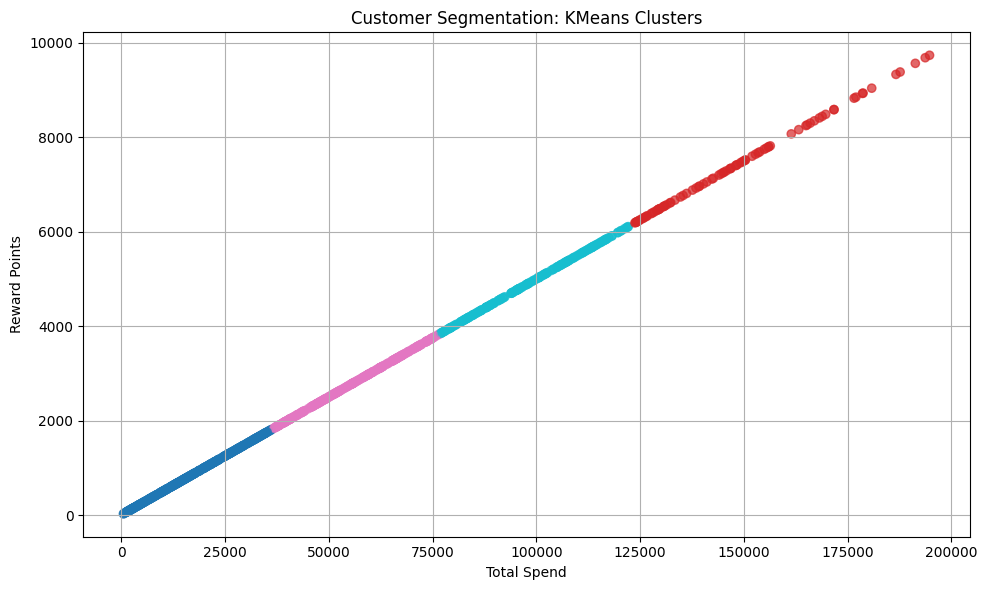

In [0]:
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

# 1. Start Spark session
spark = SparkSession.builder.getOrCreate()

# 2. Load the dataset
df = spark.read.format("delta").load("/mnt/cleaned_data/profile_df")


# 3. Select relevant features
features_cols = ["Total_Orders", "Total_Spend", "Purchase_Frequency", "Reward_Points", "Avg_Discount_Used"]
df_cleaned = df.select(*features_cols).dropna()

# 4. Add index to original and cleaned DataFrame
df_cleaned = df_cleaned.withColumn("row_id", monotonically_increasing_id())
df_original = df.withColumn("row_id", monotonically_increasing_id())

# 5. Assemble features
assembler = VectorAssembler(inputCols=features_cols, outputCol="features")
assembled = assembler.transform(df_cleaned)

# 6. Apply KMeans
kmeans = KMeans(k=4, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(assembled)
clustered = model.transform(assembled)

# 7. Join cluster result back to original dataset
clustered_with_id = clustered.select("row_id", "cluster")
final_df = df_original.join(clustered_with_id, on="row_id").drop("row_id")

# 8. Convert to Pandas for visualization
pandas_df = final_df.select("Total_Spend", "Reward_Points", "cluster").toPandas()

# 9. Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df["Total_Spend"], pandas_df["Reward_Points"], c=pandas_df["cluster"], cmap='tab10', alpha=0.7)
plt.xlabel("Total Spend")
plt.ylabel("Reward Points")
plt.title("Customer Segmentation: KMeans Clusters")
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. Export to Azure SQL
jdbc_url = "jdbc:sqlserver://geeta.database.windows.net:1433;databaseName=db_dev"
connection_properties = {
    "user": "geeta@geeta",
    "password": "Chaitu@13",
    "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}
final_df.write.jdbc(jdbc_url, "Customer_Segments", "overwrite", connection_properties)